# Knowledge Graph Extraction

In this guide, we use [outlines](https://outlines-dev.github.io/outlines/) extract a knowledge graph from unstructured text with the quantized `Hermes-2-Pro-Llama-3-8B`.

## Requirements

### Install llama-cpp-python and outlines

In [1]:
# RUN IT ONLY ONCE TO INSTALL THE REQUIREMENTS
# %pip install llama-cpp-python outlines

For detailed installation instructions, see [llama-cpp-python installation](https://llama-cpp-python.readthedocs.io/en/stable/) and [outlines installation](https://outlines-dev.github.io/outlines/installation/)

### Pull the model from HuggingFace

Download a GGUF model from HuggingFace [here](https://huggingface.co/NousResearch/Hermes-2-Pro-Llama-3-8B-GGUF/tree/main), for example, the Q4_K_M one (it requires 4.92 GB):

In [2]:
# RUN IT ONLY ONCE TO DOWNLOAD THE GGUF MODEL, IN THIS CASE THE Q4_K_M
# !wget https://hf.co/NousResearch/Hermes-2-Pro-Llama-3-8B-GGUF/resolve/main/Hermes-2-Pro-Llama-3-8B-Q4_K_M.gguf

## Usage

### Knowledge Graph Extraction

### Define Pydantic class

We first need to define our Pydantic class for each node and each edge of the knowledge graph:

In [3]:
from pydantic import BaseModel, Field

class Node(BaseModel):
    """Node of the Knowledge Graph"""

    id: int = Field(..., description="Unique identifier of the node")
    label: str = Field(..., description="Label of the node")
    property: str = Field(..., description="Property of the node")


class Edge(BaseModel):
    """Edge of the Knowledge Graph"""

    source: int = Field(..., description="Unique source of the edge")
    target: int = Field(..., description="Unique target of the edge")
    label: str = Field(..., description="Label of the edge")
    property: str = Field(..., description="Property of the edge")

We then define the Pydantic class for the knowledge graph

In [4]:
from typing import List

class KnowledgeGraph(BaseModel):
    """Generated Knowledge Graph"""

    nodes: List[Node] = Field(..., description="List of nodes of the knowledge graph")
    edges: List[Edge] = Field(..., description="List of edges of the knowledge graph")

### Load the model

In [5]:
import llama_cpp
from llama_cpp import Llama
from outlines import generate, models

llm = Llama(
    "/big_storage/llms/models/Hermes-2-Pro-Llama-3-8B-Q4_K_M.gguf",
    tokenizer=llama_cpp.llama_tokenizer.LlamaHFTokenizer.from_pretrained(
        "NousResearch/Hermes-2-Pro-Llama-3-8B"
    ),
    n_gpu_layers=-1,
    flash_attn=True,
    n_ctx=8192,
    verbose=False
)

model = models.LlamaCpp(llm)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) # ignore runtime warnings

We build a regex from the `KnowledgeGraph` Pydantic class which the model will be forced to follow

In [7]:
from outlines.integrations.utils import convert_json_schema_to_str
from outlines.fsm.json_schema import build_regex_from_schema

json_schema = KnowledgeGraph.model_json_schema()
schema_str = convert_json_schema_to_str(json_schema=json_schema)
regex_str = build_regex_from_schema(schema_str)
regex_str

'\\{[ ]?"nodes"[ ]?:[ ]?\\[[ ]?((\\{[ ]?"id"[ ]?:[ ]?(-)?(0|[1-9][0-9]*)[ ]?,[ ]?"label"[ ]?:[ ]?"([^"\\\\\\x00-\\x1F\\x7F-\\x9F]|\\\\["\\\\])*"[ ]?,[ ]?"property"[ ]?:[ ]?"([^"\\\\\\x00-\\x1F\\x7F-\\x9F]|\\\\["\\\\])*"[ ]?\\})(,[ ]?(\\{[ ]?"id"[ ]?:[ ]?(-)?(0|[1-9][0-9]*)[ ]?,[ ]?"label"[ ]?:[ ]?"([^"\\\\\\x00-\\x1F\\x7F-\\x9F]|\\\\["\\\\])*"[ ]?,[ ]?"property"[ ]?:[ ]?"([^"\\\\\\x00-\\x1F\\x7F-\\x9F]|\\\\["\\\\])*"[ ]?\\})){0,})?[ ]?\\][ ]?,[ ]?"edges"[ ]?:[ ]?\\[[ ]?((\\{[ ]?"source"[ ]?:[ ]?(-)?(0|[1-9][0-9]*)[ ]?,[ ]?"target"[ ]?:[ ]?(-)?(0|[1-9][0-9]*)[ ]?,[ ]?"label"[ ]?:[ ]?"([^"\\\\\\x00-\\x1F\\x7F-\\x9F]|\\\\["\\\\])*"[ ]?,[ ]?"property"[ ]?:[ ]?"([^"\\\\\\x00-\\x1F\\x7F-\\x9F]|\\\\["\\\\])*"[ ]?\\})(,[ ]?(\\{[ ]?"source"[ ]?:[ ]?(-)?(0|[1-9][0-9]*)[ ]?,[ ]?"target"[ ]?:[ ]?(-)?(0|[1-9][0-9]*)[ ]?,[ ]?"label"[ ]?:[ ]?"([^"\\\\\\x00-\\x1F\\x7F-\\x9F]|\\\\["\\\\])*"[ ]?,[ ]?"property"[ ]?:[ ]?"([^"\\\\\\x00-\\x1F\\x7F-\\x9F]|\\\\["\\\\])*"[ ]?\\})){0,})?[ ]?\\][ ]?\\}'

We then need to adapt our prompt to the [Hermes prompt format for JSON schema](https://github.com/NousResearch/Hermes-Function-Calling?tab=readme-ov-file#prompt-format-for-json-mode--structured-outputs)

In [8]:
def generate_hermes_prompt(user_prompt):
    return (
        "<|im_start|>system\n"
        "You are a world class AI model who answers questions in JSON with correct Pydantic schema. "
        "Here's the json schema you must adhere to:\n<schema>\n" + str(json_schema) + "\n</schema>"
        "\n<|im_start|>user\n" + user_prompt + "<|im_end|>"
        "\n<|im_start|>assistant\n"
    )

In [9]:
def generate_hermes_prompt(user_prompt):
    return (
        "<|im_start|>system\n"
        "You are a world class AI model who answers questions in JSON "
        f"Here's the json schema you must adhere to:\n<schema>\n{json_schema}\n</schema><|im_end|>\n"
        "<|im_start|>user\n"
        + user_prompt
        + "<|im_end|>"
        + "\n<|im_start|>assistant\n"
        "<schema>"
    )

For a given `user_prompt` we obtain the hermes prompt

In [10]:
user_prompt = "Alice loves Bob and she hates Charlie."
prompt = generate_hermes_prompt(user_prompt)
print(prompt)

<|im_start|>system
You are a world class AI model who answers questions in JSON Here's the json schema you must adhere to:
<schema>
{'$defs': {'Edge': {'description': 'Edge of the Knowledge Graph', 'properties': {'source': {'description': 'Unique source of the edge', 'title': 'Source', 'type': 'integer'}, 'target': {'description': 'Unique target of the edge', 'title': 'Target', 'type': 'integer'}, 'label': {'description': 'Label of the edge', 'title': 'Label', 'type': 'string'}, 'property': {'description': 'Property of the edge', 'title': 'Property', 'type': 'string'}}, 'required': ['source', 'target', 'label', 'property'], 'title': 'Edge', 'type': 'object'}, 'Node': {'description': 'Node of the Knowledge Graph', 'properties': {'id': {'description': 'Unique identifier of the node', 'title': 'Id', 'type': 'integer'}, 'label': {'description': 'Label of the node', 'title': 'Label', 'type': 'string'}, 'property': {'description': 'Property of the node', 'title': 'Property', 'type': 'string'

We use `generate.regex` by passing the `regex_str` from the Pydantic class we previously defined, and call the generator with the Hermes prompt:

In [11]:
generator = generate.regex(model, regex_str)
response = generator(prompt, max_tokens=1024, temperature=0, seed=42)

We obtain the nodes and edges of the knowledge graph

In [12]:
import json

json_response = json.loads(response)
json_response["nodes"]

[{'id': 1, 'label': 'Alice', 'property': 'person'},
 {'id': 2, 'label': 'Bob', 'property': 'person'},
 {'id': 3, 'label': 'Charlie', 'property': 'person'}]

In [13]:
json_response["edges"]

[{'source': 1, 'target': 2, 'label': 'love', 'property': 'relationship'},
 {'source': 1, 'target': 3, 'label': 'hate', 'property': 'relationship'}]

## (Optional) Visualizing the Knowledge Graph

We can use the [Graphviz library](https://graphviz.readthedocs.io/en/stable/) to visualize the generated knowledge graph. For detailed installation instructions, see [here](https://graphviz.readthedocs.io/en/stable/#installation).

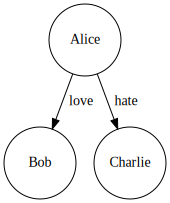

In [14]:
from graphviz import Digraph

dot = Digraph()
for node in json_response["nodes"]:
    dot.node(str(node["id"]), node["label"], shape='circle', width='1', height='1')
for edge in json_response["edges"]:
    dot.edge(str(edge["source"]), str(edge["target"]), label=edge["label"])

dot